### 75.06/95.58 Organización de Datos: Trabajo Práctico 1 ###
#### Primer Cuatrimestre de 2020 ####



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

tweets = pd.read_csv('train.csv') 
tweets.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [2]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
tweets['text'].describe()

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

In [4]:
tweets['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [5]:
tweets['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [6]:
duplicados = tweets.duplicated(subset = 'text', keep = False)
duplicados.value_counts()

False    7434
True      179
dtype: int64

In [7]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7434 non-null   int64 
 1   keyword   7378 non-null   object
 2   location  4982 non-null   object
 3   text      7434 non-null   object
 4   target    7434 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


TOP 50 DESASTRES COMENTADOS EN LOS TWEETS

In [8]:
desastres = tweets.groupby("keyword").agg({"target":["count","mean"]}).copy()
level0 = desastres.columns.get_level_values(0)
level1 = desastres.columns.get_level_values(1)
desastres.columns = level0 + "_" + level1
desastres.sort_values(by="target_count",ascending = False,inplace = True)
desastres = desastres.head(50) #TOP 50

[]

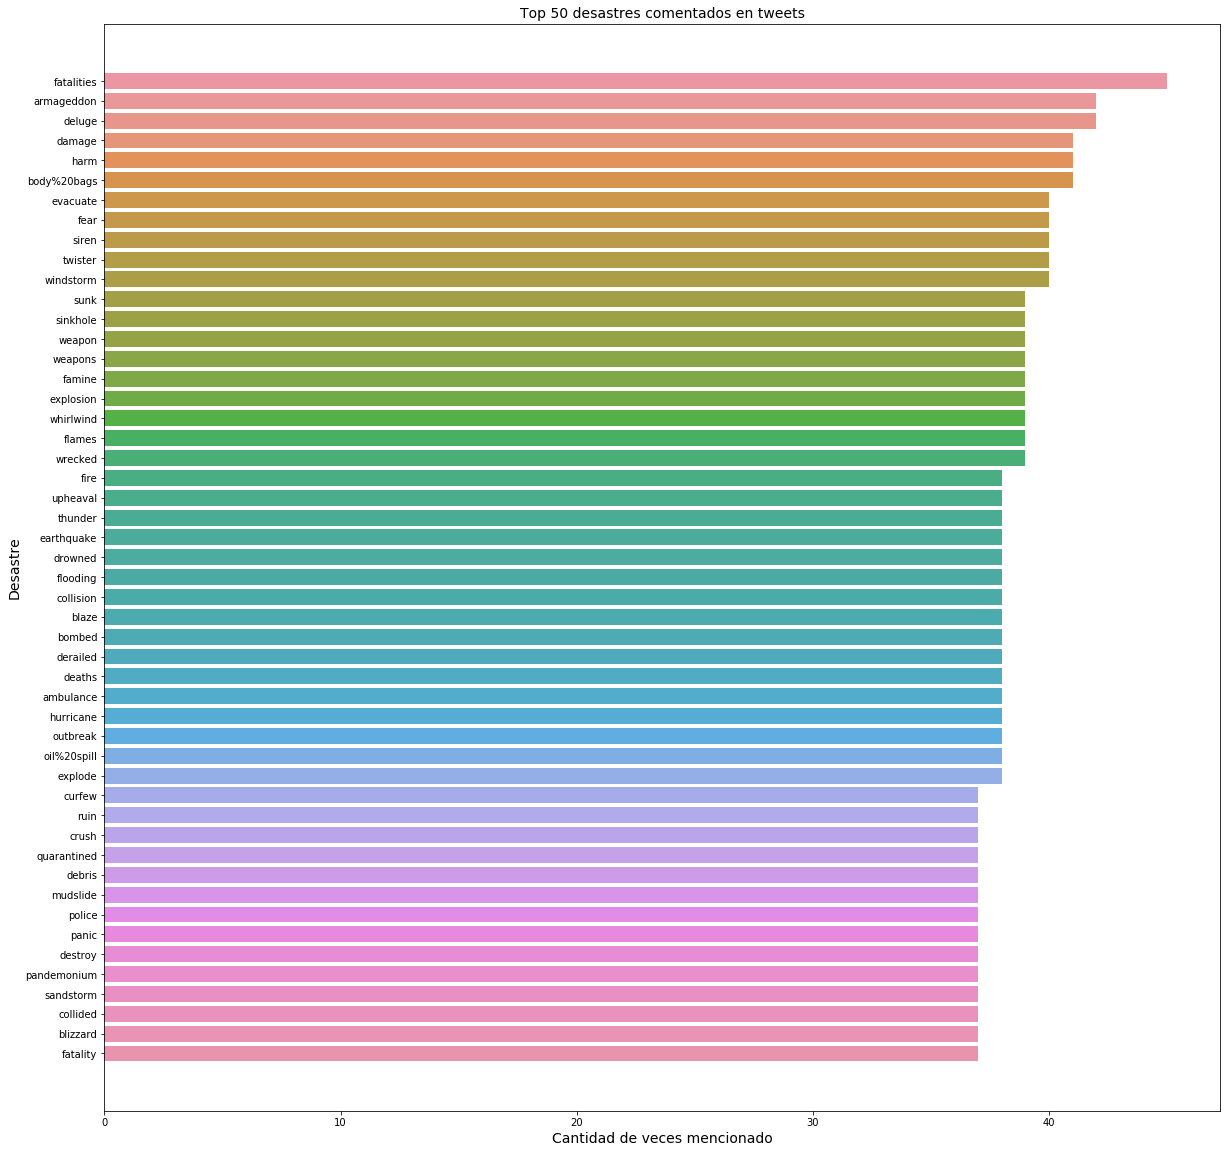

In [9]:
fig = plt.figure(figsize=(20,20))
grafico = sns.barplot(data = desastres,x = "target_count",y = desastres.index)
grafico.set_title("Top 50 desastres comentados en tweets",fontsize = 14)
grafico.set_xlabel("Cantidad de veces mencionado",fontsize = 14)
grafico.set_ylabel("Desastre",fontsize = 14)
grafico.plot()

## Análisis por longitud de tweet.

In [10]:
tweets_length = tweets[['text','target']]

tweets_length.count()

text      7434
target    7434
dtype: int64

In [11]:
tweets_length['text'].hasnans

False

In [12]:
tweets_length['length'] = tweets_length['text'].str.len()
tweets_length.head()

,text,target,length
0,Our Deeds are the Reason of this #earthquake M...,1,69
1,Forest fire near La Ronge Sask. Canada,1,38
2,All residents asked to 'shelter in place' are ...,1,133
3,"13,000 people receive #wildfires evacuation or...",1,65
4,Just got sent this photo from Ruby #Alaska as ...,1,88


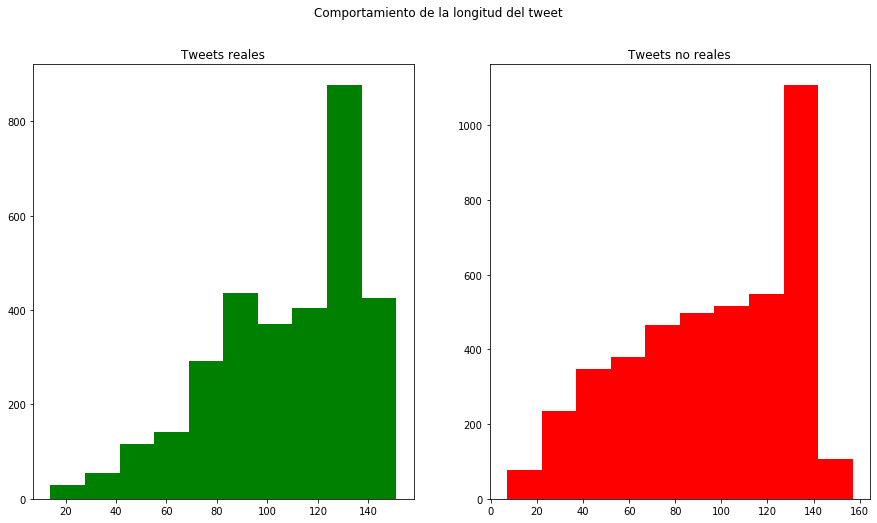

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,8))
tweet_len = tweets_length[tweets_length['target'] == 1]['length']
ax1.hist(tweet_len,color='green')
ax1.set_title('Tweets reales')
tweet_len = tweets_length[tweets_length['target'] == 0]['length']
ax2.hist(tweet_len,color='red')
ax2.set_title('Tweets no reales')
fig.suptitle('Comportamiento de la longitud del tweet')
plt.show()

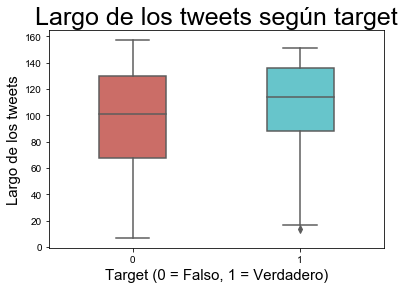

In [14]:
g = sns.boxplot(x = 'target', y = 'length', data = tweets_length, palette = 'hls', width = 0.4)
g.set_title("Largo de los tweets según target", fontsize = 25)
g.set_xlabel("Target (0 = Falso, 1 = Verdadero)", fontsize = 15)
g.set_ylabel("Largo de los tweets", fontsize = 15)
sns.set(rc = {'figure.figsize' : (15,10)})

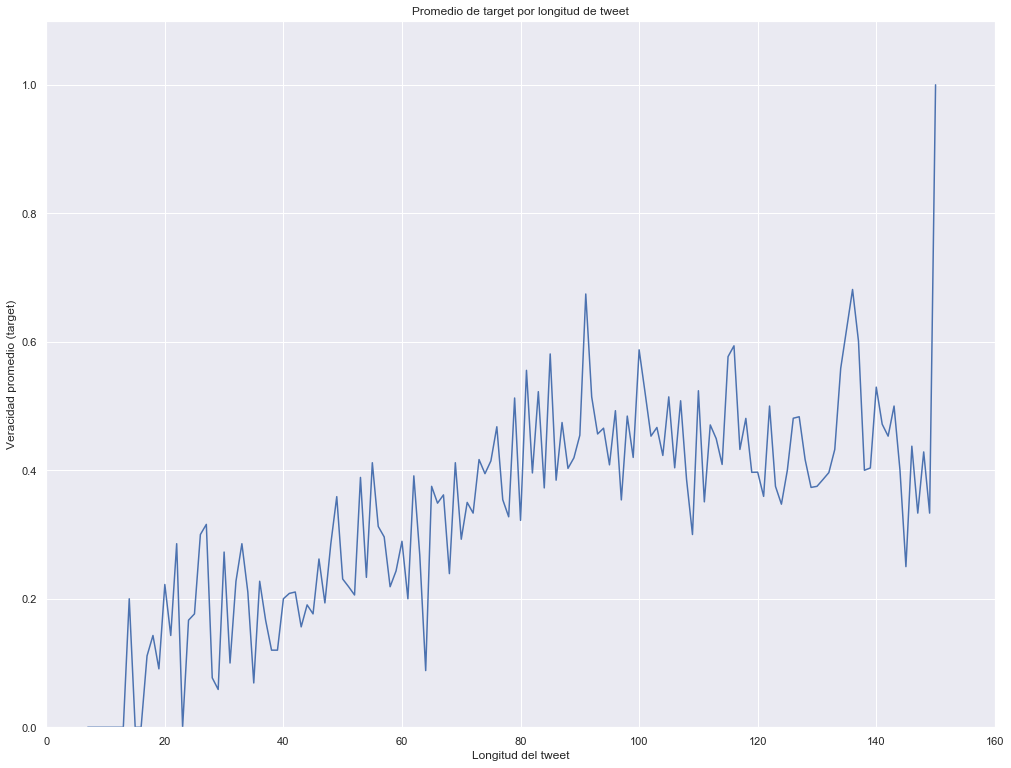

In [15]:
#ESTE ES CANDIDATO A VOLAR DE ACA, no sirve ---> Reemplazar por el scatter de Agus
grouped = tweets_length.groupby('length')['target'].agg(['mean','count'])

grouped[(grouped['count'] >= 2)]['mean'].plot(kind = "line",figsize = (17,13))
plt.title('Promedio de target por longitud de tweet')
plt.xlabel('Longitud del tweet')
plt.ylabel('Veracidad promedio (target)')
plt.xlim(0,160)
plt.ylim(0,1.1)
plt.show()

In [16]:
tweets_length['avg_word_length'] = tweets_length['text'].str.split().apply(lambda x: [len(y) for y in x]).transform(lambda x: np.mean(x))
tweets_length.head()

,text,target,length,avg_word_length
0,Our Deeds are the Reason of this #earthquake M...,1,69,4.384615
1,Forest fire near La Ronge Sask. Canada,1,38,4.571429
2,All residents asked to 'shelter in place' are ...,1,133,5.090909
3,"13,000 people receive #wildfires evacuation or...",1,65,7.125000
4,Just got sent this photo from Ruby #Alaska as ...,1,88,4.500000


In [17]:
fig = px.histogram(tweets_length, x="avg_word_length", color="target", marginal="box", width = 1200, height = 550,
                             nbins = 300, title = 'Distribución de largo promedio de palabras por tweet individual')
fig.show()

In [18]:
tweets_length['amount_of_words'] = tweets_length['text'].str.split().transform(lambda x: len(x))
tweets_length.head()

,text,target,length,avg_word_length,amount_of_words
0,Our Deeds are the Reason of this #earthquake M...,1,69,4.384615,13
1,Forest fire near La Ronge Sask. Canada,1,38,4.571429,7
2,All residents asked to 'shelter in place' are ...,1,133,5.090909,22
3,"13,000 people receive #wildfires evacuation or...",1,65,7.125000,8
4,Just got sent this photo from Ruby #Alaska as ...,1,88,4.500000,16


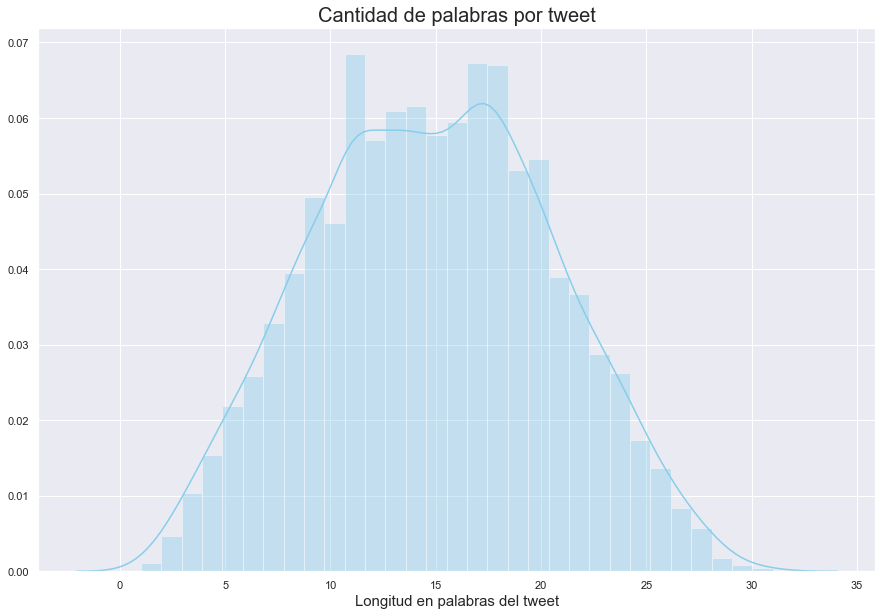

In [19]:
g = sns.distplot(tweets_length['amount_of_words'], bins = 31, color = 'SkyBlue')
g.set_title('Cantidad de palabras por tweet', fontsize = 20)
g.set_xlabel('Longitud en palabras del tweet', fontsize = 15)
plt.show()

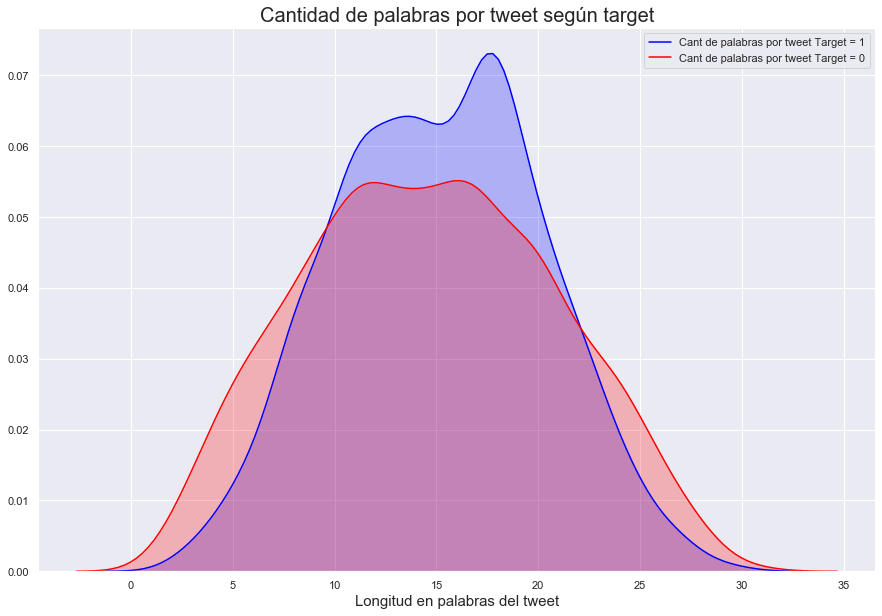

In [20]:
g = sns.kdeplot(tweets_length[tweets_length['target'] == 1]['amount_of_words'], color="blue", label='Cant de palabras por tweet Target = 1', shade=True)
g = sns.kdeplot(tweets_length[tweets_length['target'] == 0]['amount_of_words'], color="red", label='Cant de palabras por tweet Target = 0', shade=True)



#g = sns.distplot(tweets_length['amount_of_words'], bins = 31, color = 'black')
g.set_title('Cantidad de palabras por tweet según target', fontsize = 20)
g.set_xlabel('Longitud en palabras del tweet', fontsize = 15)
plt.show()

In [21]:
#Cantidad de palabras únicas (aka sin repetir) en el tweet
#unique_words_by_tweet = tweets_length['text'].apply(lambda x: x.split()).apply(lambda x: pd.Series(x).unique()).map(lambda x: len(x))
unique_words_by_tweet = tweets_length['text'].transform(lambda x: x.split()).transform(lambda x: pd.Series(x).unique()).transform(lambda x: len(x))
tweets_length['amount_of_unique_words'] = unique_words_by_tweet
tweets_length


,text,target,length,avg_word_length,amount_of_words,amount_of_unique_words
0,Our Deeds are the Reason of this #earthquake M...,1,69,4.384615,13,13
1,Forest fire near La Ronge Sask. Canada,1,38,4.571429,7,7
2,All residents asked to 'shelter in place' are ...,1,133,5.090909,22,20
3,"13,000 people receive #wildfires evacuation or...",1,65,7.125000,8,8
4,Just got sent this photo from Ruby #Alaska as ...,1,88,4.500000,16,15
...,...,...,...,...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1,136,6.210526,19,19
7605,on the flip side I'm at Walmart and there is a...,1,114,3.423077,26,25
7606,Suicide bomber kills 15 in Saudi security site...,1,121,5.100000,20,18
7608,Two giant cranes holding a bridge collapse int...,1,83,6.636364,11,11


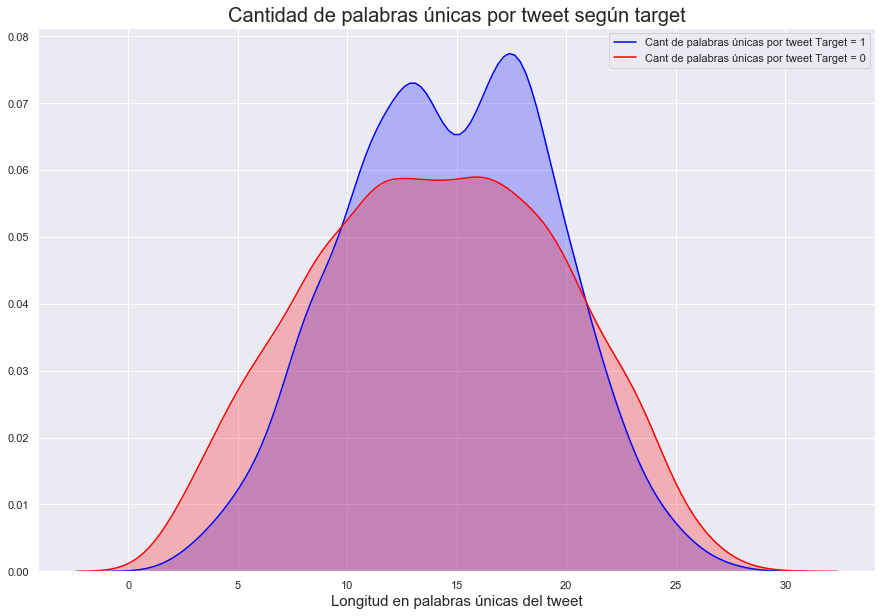

In [22]:
#Hipotesis: los de target 1 no repiten tantas palabras (?).
#Resultado: son casi lo mismo pero weno podemos dejarlo.
g = sns.kdeplot(tweets_length[tweets_length['target'] == 1]['amount_of_unique_words'], color="blue", label='Cant de palabras únicas por tweet Target = 1', shade=True)
g = sns.kdeplot(tweets_length[tweets_length['target'] == 0]['amount_of_unique_words'], color="red", label='Cant de palabras únicas por tweet Target = 0', shade=True)


#g = sns.distplot(tweets_length['amount_of_words'], bins = 31, color = 'black')
g.set_title('Cantidad de palabras únicas por tweet según target', fontsize = 20)
g.set_xlabel('Longitud en palabras únicas del tweet', fontsize = 15)
plt.show()

In [23]:
tweets_length['avg_length'] = tweets_length.groupby('target')['length'].transform('mean')
tweets_length.head()

,text,target,length,avg_word_length,amount_of_words,amount_of_unique_words,avg_length
0,Our Deeds are the Reason of this #earthquake M...,1,69,4.384615,13,13,108.095238
1,Forest fire near La Ronge Sask. Canada,1,38,4.571429,7,7,108.095238
2,All residents asked to 'shelter in place' are ...,1,133,5.090909,22,20,108.095238
3,"13,000 people receive #wildfires evacuation or...",1,65,7.125000,8,8,108.095238
4,Just got sent this photo from Ruby #Alaska as ...,1,88,4.500000,16,15,108.095238


In [24]:
tweets_length['is_above_avg_length'] = tweets_length['length'] > tweets_length['avg_length']
tweets_length.head()

,text,target,length,avg_word_length,amount_of_words,amount_of_unique_words,avg_length,is_above_avg_length
0,Our Deeds are the Reason of this #earthquake M...,1,69,4.384615,13,13,108.095238,False
1,Forest fire near La Ronge Sask. Canada,1,38,4.571429,7,7,108.095238,False
2,All residents asked to 'shelter in place' are ...,1,133,5.090909,22,20,108.095238,True
3,"13,000 people receive #wildfires evacuation or...",1,65,7.125000,8,8,108.095238,False
4,Just got sent this photo from Ruby #Alaska as ...,1,88,4.500000,16,15,108.095238,False


In [25]:
groupedby_is_above_avg_length = tweets_length.groupby('is_above_avg_length').agg({'target':['mean','count']})
groupedby_is_above_avg_length

target      
                         mean count
is_above_avg_length                
False                0.419517  3392
True                 0.427264  4042

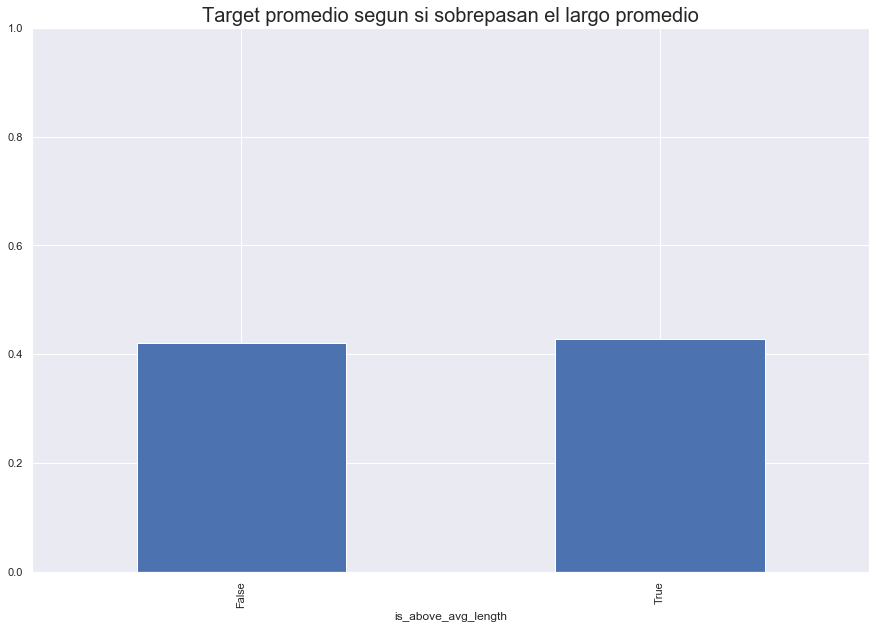

In [26]:
groupedby_is_above_avg_length[('target','mean')].plot(kind = 'bar', figsize = (15,10))
plt.title('Target promedio segun si sobrepasan el largo promedio', fontsize = 20)
plt.ylim(0,1)
plt.show()

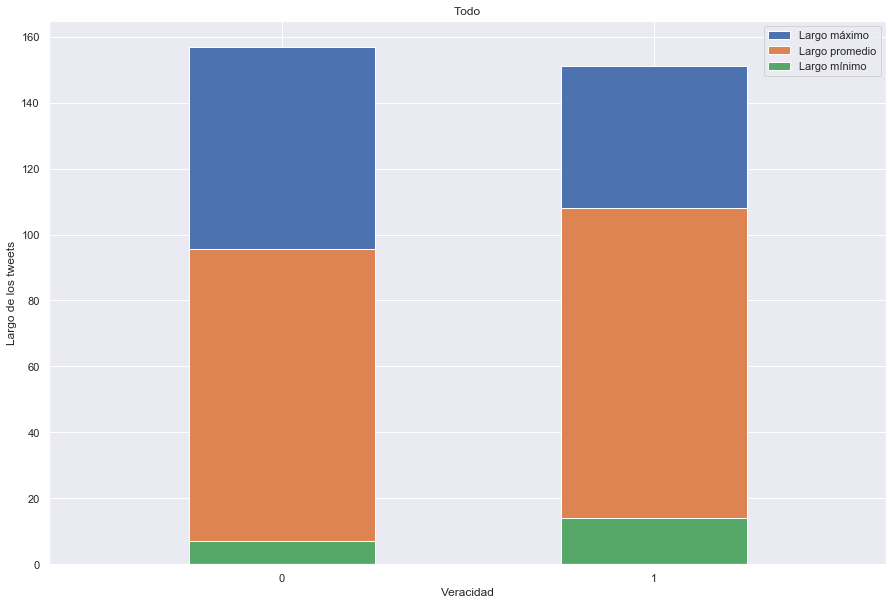

In [27]:
#grafico de promedio de longitud por target
visualizacion = tweets_length.groupby('target').agg({'length':['mean','max','min']})

c = visualizacion.columns.get_level_values(0)
v = visualizacion.columns.get_level_values(1)
visualizacion.columns = c + '_' + v
visualizacion.reset_index()


fig, ax = plt.subplots(figsize = (15,10))
ax.bar(visualizacion.index, visualizacion['length_max'],0.5, label='largo_max')
ax.bar(visualizacion.index, visualizacion['length_mean'],0.5, label='largo_mean')

ax.bar(visualizacion.index, visualizacion['length_min'],0.5, label='largo_min')

plt.margins(x=0.25)
plt.xticks([0,1])
ax.set_xlabel('Veracidad')
ax.set_ylabel('Largo de los tweets')
ax.set_title('Todo')
ax.legend(['Largo máximo','Largo promedio', 'Largo mínimo'], loc = 'upper right');
plt.show()

In [28]:
# generamos una columna para agregar y procesar mediante una tabla pivot


tweets_length['is_a_tweet'] = 1
for_heatmap = tweets_length.pivot_table(index = 'length', columns = 'target', values = 'is_a_tweet', aggfunc = 'sum')
for_heatmap

target,0,1
length,,
7,3.0,NaN
8,4.0,NaN
9,2.0,NaN
10,2.0,NaN
11,4.0,NaN
...,...,...
150,NaN,2.0
151,NaN,1.0
152,1.0,NaN


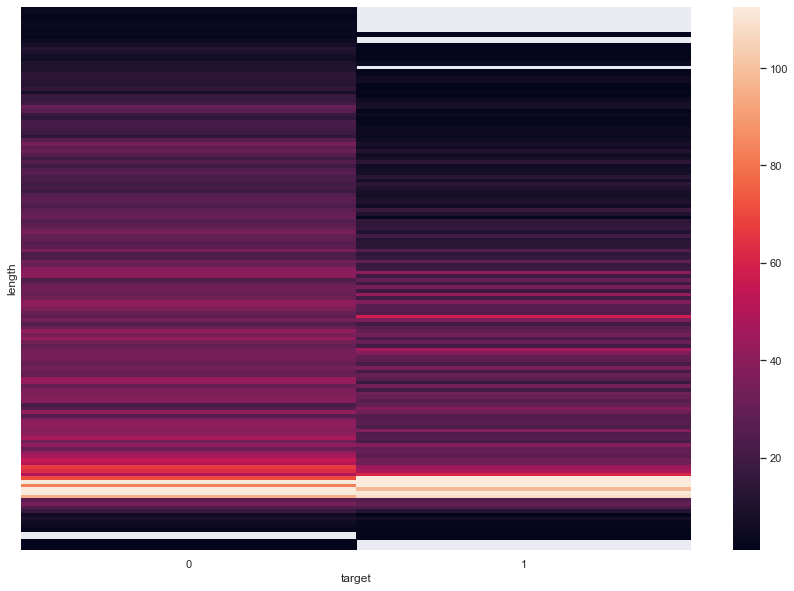

In [29]:
#Candidato a volar
g = sns.heatmap(for_heatmap, robust = True, yticklabels = False)#, cmap="YlGnBu")#, square = True)#, linewidths=1)

In [30]:
fig = px.density_heatmap(tweets_length, x='target', y="length")
fig.show()

In [31]:
tweets_to_corr = tweets_length[['length','target']]
tweets_to_corr.corr(method = 'pearson')

,length,target
length,1.000000,0.181208
target,0.181208,1.000000


In [32]:
tweets_length

,text,target,length,avg_word_length,amount_of_words,amount_of_unique_words,avg_length,is_above_avg_length,is_a_tweet
0,Our Deeds are the Reason of this #earthquake M...,1,69,4.384615,13,13,108.095238,False,1
1,Forest fire near La Ronge Sask. Canada,1,38,4.571429,7,7,108.095238,False,1
2,All residents asked to 'shelter in place' are ...,1,133,5.090909,22,20,108.095238,True,1
3,"13,000 people receive #wildfires evacuation or...",1,65,7.125000,8,8,108.095238,False,1
4,Just got sent this photo from Ruby #Alaska as ...,1,88,4.500000,16,15,108.095238,False,1
...,...,...,...,...,...,...,...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1,136,6.210526,19,19,108.095238,True,1
7605,on the flip side I'm at Walmart and there is a...,1,114,3.423077,26,25,108.095238,True,1
7606,Suicide bomber kills 15 in Saudi security site...,1,121,5.100000,20,18,108.095238,True,1
7608,Two giant cranes holding a bridge collapse int...,1,83,6.636364,11,11,108.095238,False,1


In [33]:

tweets_to_corr = tweets_length[['length','target','is_above_avg_length','avg_word_length','amount_of_words','amount_of_unique_words']]
#tweets_to_corr['mean'] = tweets_length['length'].mean()
tweets_to_corr['avg_target_by_length'] = tweets_length.groupby('length')['target'].transform('mean')
tweets_to_corr.head(20)
tweets_to_corr.corr(method = 'spearman')

,length,target,is_above_avg_length,avg_word_length,amount_of_words,amount_of_unique_words,avg_target_by_length
length,1.000000,0.162665,0.852293,0.059206,0.831505,0.835720,0.561074
target,0.162665,1.000000,0.007809,0.222487,0.042861,0.050607,0.261479
is_above_avg_length,0.852293,0.007809,1.000000,0.009538,0.753051,0.754562,0.404196
avg_word_length,0.059206,0.222487,0.009538,1.000000,-0.427486,-0.398531,0.129454
amount_of_words,0.831505,0.042861,0.753051,-0.427486,1.000000,0.986645,0.469784
amount_of_unique_words,0.835720,0.050607,0.754562,-0.398531,0.986645,1.000000,0.473540
avg_target_by_length,0.561074,0.261479,0.404196,0.129454,0.469784,0.473540,1.000000


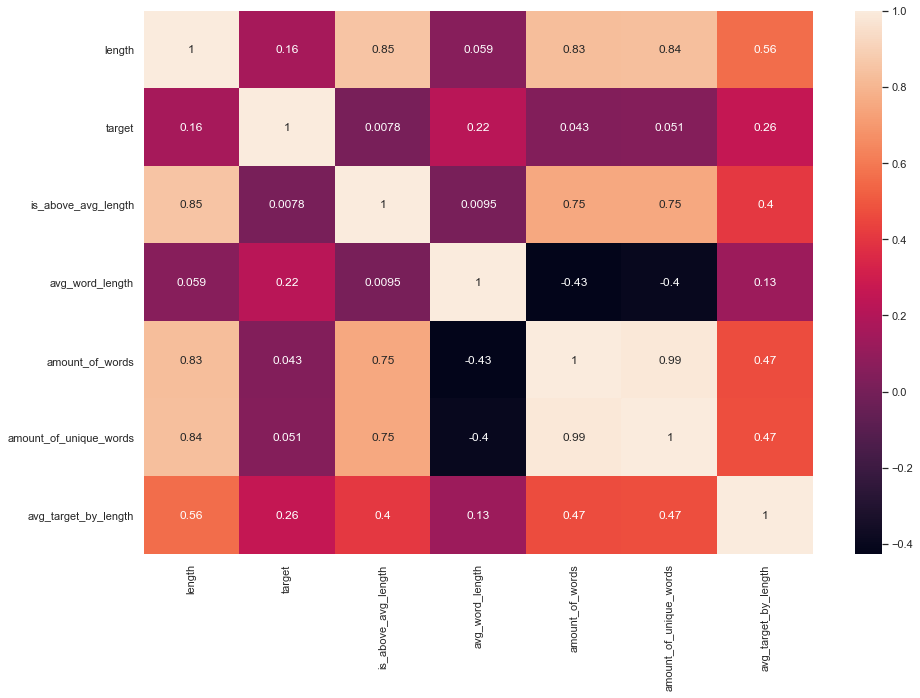

In [34]:
#Candidato a volar
sns.heatmap(tweets_to_corr.corr(method = 'spearman'), annot = True)
plt.show()

## Bueno hasta acá todo lo relacionado a longitud

## Ahora vamos con relacion links en tweet vs veracidad
Si contienen links ver su target

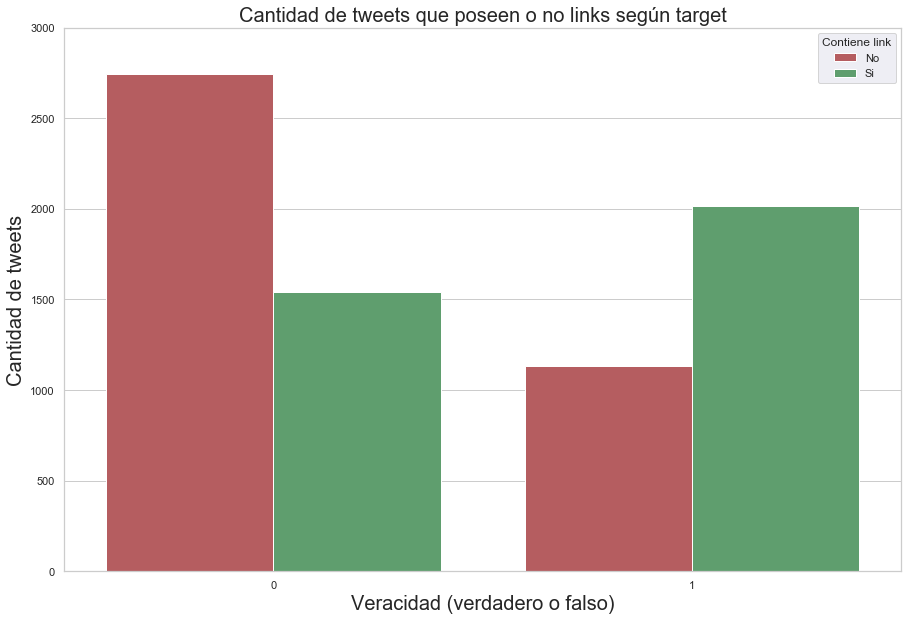

In [35]:
tweets_length['contains_link'] = tweets_length['text'].str.contains('http://' or 'https://')

sns.set(style="whitegrid")
g = sns.countplot(x = 'target', hue = "contains_link", data = tweets_length, palette = [sns.color_palette()[3], sns.color_palette()[2]])


g.set_title('Cantidad de tweets que poseen o no links según target', fontsize = 20)
g.set_xlabel('Veracidad (verdadero o falso)', fontsize = 20)
g.set_ylabel('Cantidad de tweets', fontsize = 20)
plt.ylim(0,3000)
sns.set(rc = {'figure.figsize' : (15,10)})

g.legend(['No','Si'], loc = 'upper right', title = 'Contiene link');

plt.show()

In [36]:
#Pispeo los valores
tweets_length[tweets_length['contains_link']].groupby('target').agg({'length':['count', 'mean']})

length            
        count        mean
target                   
0        1539  110.017544
1        2017  111.790283

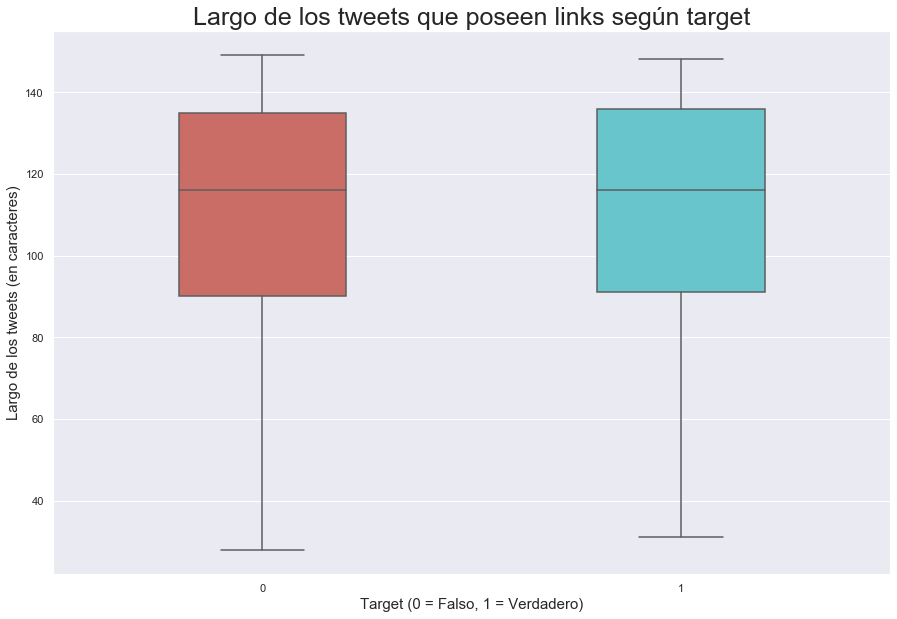

In [37]:
g = sns.boxplot(x = 'target', y = 'length', data = tweets_length[tweets_length['contains_link']], palette = 'hls', width = 0.4)
g.set_title("Largo de los tweets que poseen links según target", fontsize = 25)
g.set_xlabel("Target (0 = Falso, 1 = Verdadero)", fontsize = 15)
g.set_ylabel("Largo de los tweets (en caracteres)", fontsize = 15)
sns.set(rc = {'figure.figsize' : (15,10)})

Faltaría ver específico separando por http y https una especie de métrica para ver si lo que usan el mas seguro suelen ser mas reales (eg. links oficiales)

Según twitter developer:
When a HTTPS-based URL is passed while link wrapping is enabled, a HTTPS-based t.co link will be produced. HTTPS-based t.co links are one character longer than standard t.co links to account for the protocol change.

Esto es porque los HTTPS son más seguros.

In [38]:
a = tweets_length[tweets_length['text'].str.contains('https://')].groupby('target')['text'].count()
b = tweets_length[tweets_length['text'].str.contains('http://')].groupby('target')['text'].count()
c = pd.DataFrame({'contains_safer_link': a, 'contains_non_safer_link': b})
c

,contains_safer_link,contains_non_safer_link
target,,
0,272,1539
1,131,2017


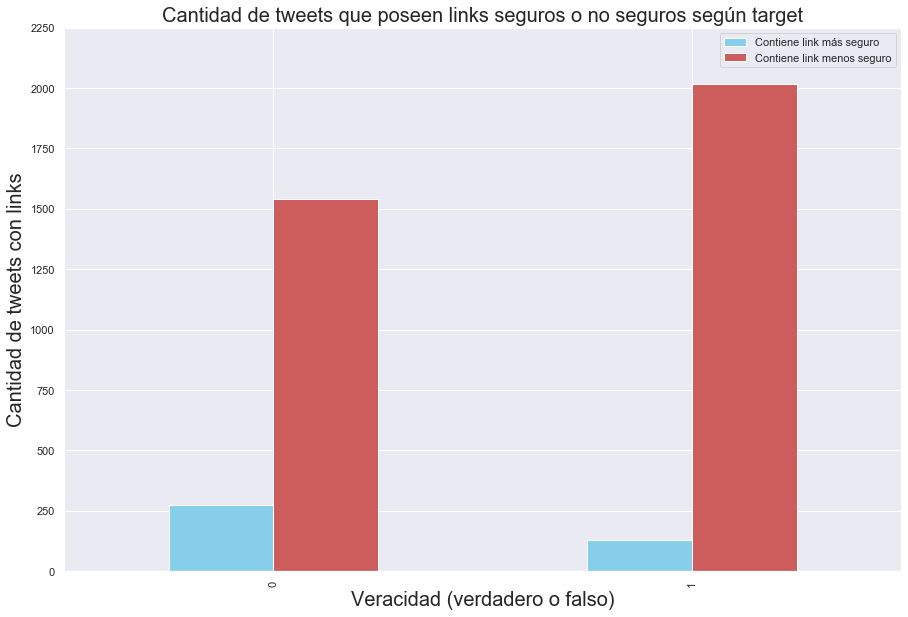

In [39]:
graph = c.plot(color=["SkyBlue","IndianRed"], kind = 'bar', figsize = (15,10))

graph.legend(['Contiene link más seguro','Contiene link menos seguro'], loc = 'upper right')
plt.title('Cantidad de tweets que poseen links seguros o no seguros según target', fontsize = 20)
plt.xlabel('Veracidad (verdadero o falso)', fontsize = 20)
plt.ylabel('Cantidad de tweets con links', fontsize = 20)
plt.ylim(0,2250)
plt.show()

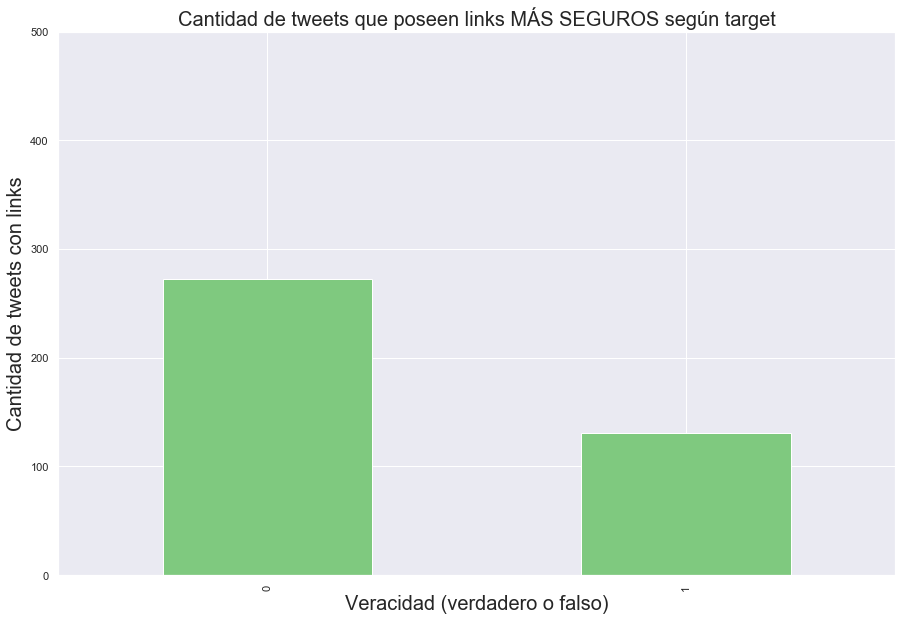

In [40]:
#Hipotesis: uno esperaria que la utilizacion de links seguros sea para los desastres reales ya que lo proveen agencias de noticias.
#Dato: Hay muy pocos links seguros en el dataset

tweets_length[tweets_length['text'].str.contains('https://')].groupby('target')['text'].count().plot(kind = 'bar', figsize = (15,10), colormap = 'Accent')

plt.title('Cantidad de tweets que poseen links MÁS SEGUROS según target', fontsize = 20)
plt.xlabel('Veracidad (verdadero o falso)', fontsize = 20)
plt.ylabel('Cantidad de tweets con links', fontsize = 20)
plt.ylim(0,500)
plt.show()

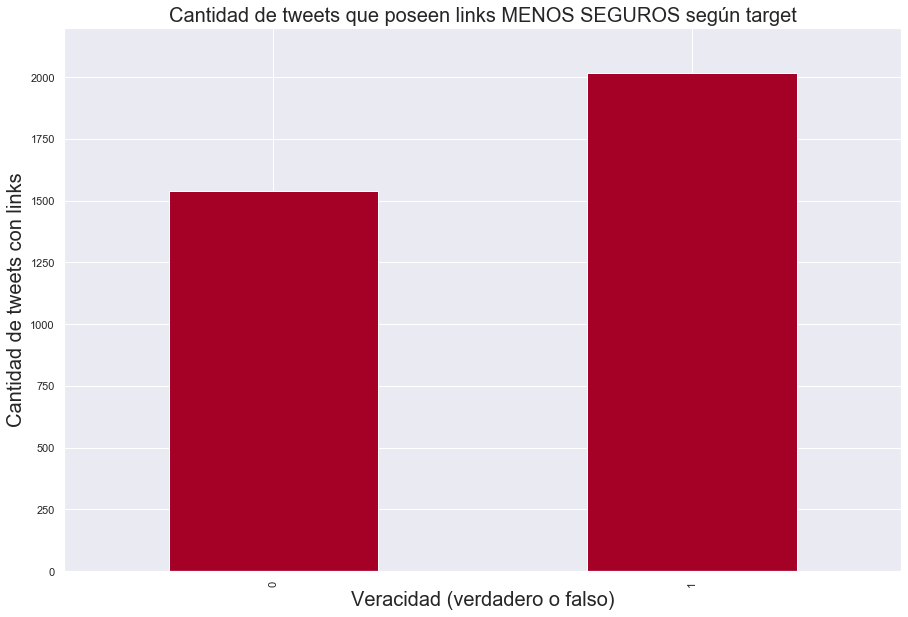

In [41]:
#Hipotesis: uno esperaria que la utilizacion de links no seguros sea para los no desastres ya que lo provee cualquiera.
#Dato: Hay muchos links inseguros en el dataset

tweets_length[tweets_length['text'].str.contains('http://')].groupby('target')['text'].count().plot(kind = 'bar', figsize = (15,10), colormap = 'RdYlBu')
plt.title('Cantidad de tweets que poseen links MENOS SEGUROS según target', fontsize = 20)
plt.xlabel('Veracidad (verdadero o falso)', fontsize = 20)
plt.ylabel('Cantidad de tweets con links', fontsize = 20)
plt.ylim(0,2200)
plt.show()

### Comienzo análisis de sentimiento de tweet.

Primera hipotesis: Al ser cosas noticiosas deberian ser mas neutras.

Pero, teniendo en cuenta que procesa el sentimiento.
Deberian ser neutros tendiendo a negativos ya que al ser desastres naturales son literalmente eso, desastres, y se espera el uso de ciertas palabras que no implican algo muy positivo.

Además, al informar sobre desastres naturales las palabras que describen este tipo de eventos apuntan en general a cosas más negativas.

Habría que ver como se puede dividir para relacionarlo con el target. Si hacer dos analisis por separado y comparar histogramas o promedios entre target 1 y 0 o usarlo combinado (que obtengo con esto?).

In [42]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mausa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [101]:
sia = SentimentIntensityAnalyzer()
def return_sia_compound_values(text):
    return sia.polarity_scores(text)['compound']

tweets_feeling_1 = tweets_length.groupby('target')['text'].get_group(1).apply(lambda x: return_sia_compound_values(x))
tweets_feeling_0 = tweets_length.groupby('target')['text'].get_group(0).apply(lambda x: return_sia_compound_values(x))

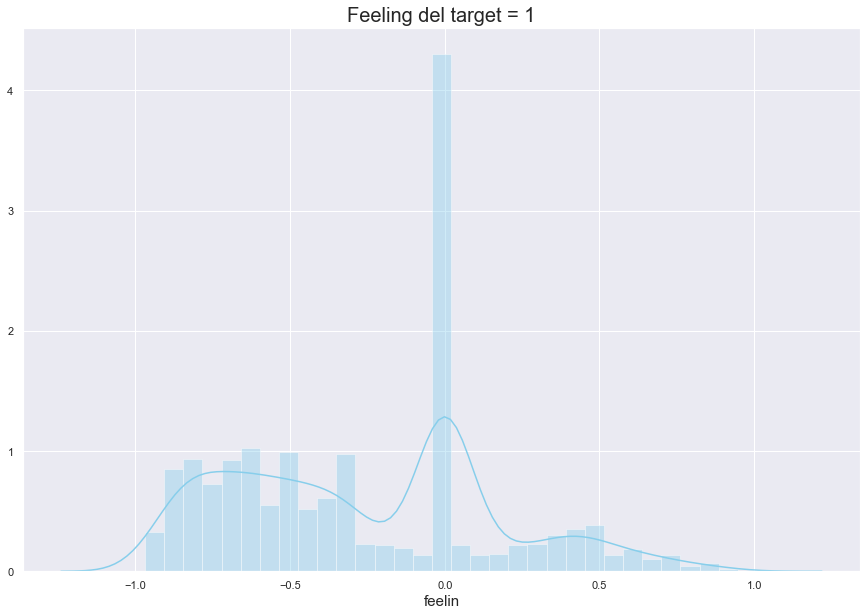

In [102]:
g = sns.distplot(tweets_feeling_1, bins = 31, color = 'SkyBlue')
g.set_title('Feeling del target = 1', fontsize = 20)
g.set_xlabel('feelin', fontsize = 15)
plt.show()

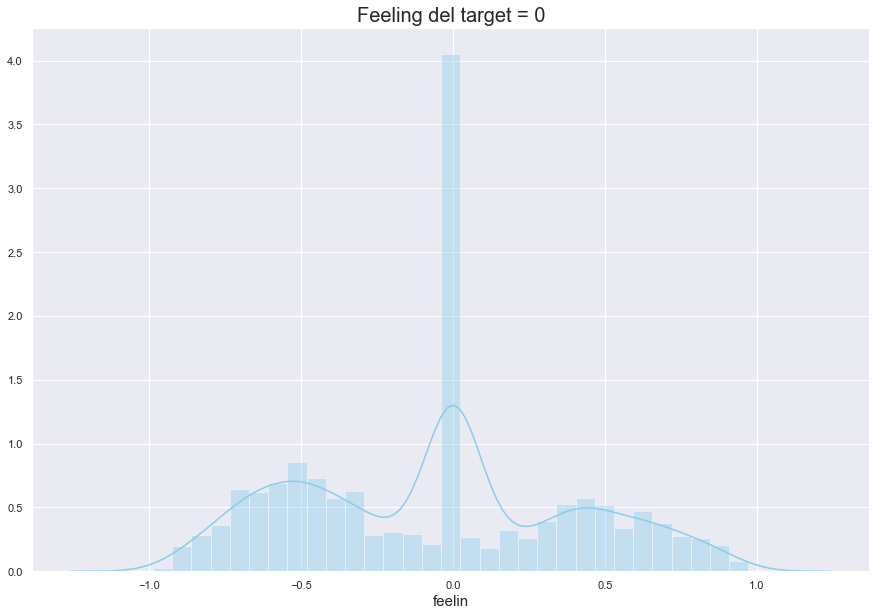

In [103]:
g = sns.distplot(tweets_feeling_0, bins = 31, color = 'SkyBlue')
g.set_title('Feeling del target = 0', fontsize = 20)
g.set_xlabel('feelin', fontsize = 15)
plt.show()

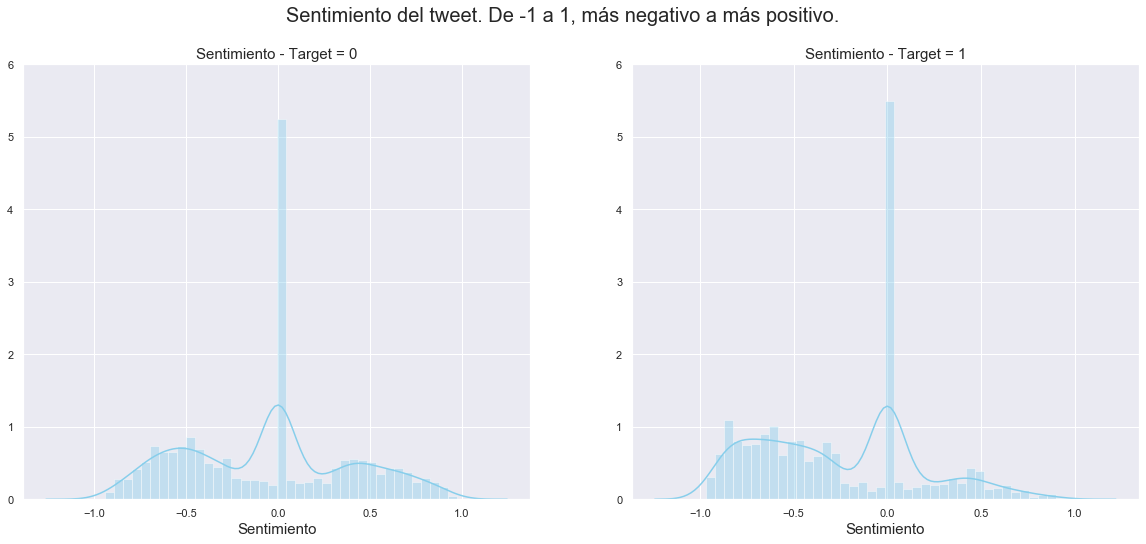

In [104]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,8))

sns.distplot(tweets_feeling_0, bins = 40, color = 'SkyBlue', ax = ax1)
ax1.set_title('Sentimiento - Target = 0', fontsize = 15)
ax1.set_xlabel('Sentimiento', fontsize = 15)

sns.distplot(tweets_feeling_1, bins = 40, color = 'SkyBlue', ax = ax2)
ax2.set_title('Sentimiento - Target = 1', fontsize = 15)
ax2.set_xlabel('Sentimiento', fontsize = 15)

ax1.set_ylim(0,6)
ax2.set_ylim(0,6)
fig.suptitle('Sentimiento del tweet. De -1 a 1, más negativo a más positivo.', fontsize = 20)
plt.show()

In [107]:
sia.polarity_scores('hijo de puta chupame la verga')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [125]:
def return_sia_values(text):
    return [sia.polarity_scores(text)['pos'], sia.polarity_scores(text)['neg'], sia.polarity_scores(text)['neu']]

sia_values = tweets_length['text'].transform(lambda x: return_sia_values(x)).to_frame()

sia_values['pos'] = sia_values['text'].apply(lambda x: pd.Series(x[0]))
sia_values['neg'] = sia_values['text'].apply(lambda x: pd.Series(x[1]))
sia_values['neu'] = sia_values['text'].apply(lambda x: pd.Series(x[2]))

sia_values['target'] = tweets_length['target']
sia_values

,text,pos,neg,neu,target
0,"[0.149, 0.0, 0.851]",0.149,0.000,0.851,1
1,"[0.0, 0.286, 0.714]",0.000,0.286,0.714,1
2,"[0.0, 0.095, 0.905]",0.000,0.095,0.905,1
3,"[0.0, 0.0, 1.0]",0.000,0.000,1.000,1
4,"[0.0, 0.0, 1.0]",0.000,0.000,1.000,1
...,...,...,...,...,...
7604,"[0.0, 0.249, 0.751]",0.000,0.249,0.751,1
7605,"[0.0, 0.122, 0.878]",0.000,0.122,0.878,1
7606,"[0.098, 0.328, 0.574]",0.098,0.328,0.574,1
7608,"[0.0, 0.262, 0.738]",0.000,0.262,0.738,1


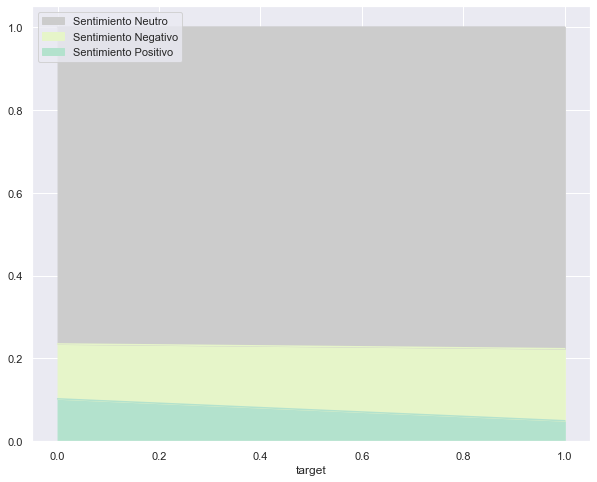

In [126]:
ax = sia_values.groupby('target').mean()[['pos', 'neg', 'neu']].plot.area(cmap='Pastel2', figsize=(10, 8))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], ['Sentimiento Neutro', 'Sentimiento Negativo', 'Sentimiento Positivo'], loc='upper left');